In [1]:
import pandas as pd
import sqlite3
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pandas import read_csv
from pygris import block_groups
import contextily as cx
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import numpy as np

warnings.filterwarnings("ignore")

data_path = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/BEAM-CORE/Lab call/PSRC/'
os.chdir(data_path)

In [2]:
# load land use data
psrc_crs = 'EPSG:2285'

baseline_parcel_path = 'v3.0.0_2018_2050/landuse/2018/v3.0_RTP/parcels_urbansim.txt'
psrc_parcels = pd.read_csv(baseline_parcel_path, sep = ' ')

# load PSRC parcel geography
parcel_geography = pd.read_csv('SoundCast_processed/parcel_2018_geography.csv')
print(len(parcel_geography))
print(parcel_geography.columns)

soundcast_input_db = 'v3.0.0_2018_2050/db/soundcast_inputs.db'
db_con = sqlite3.connect(soundcast_input_db)

psrc_parcels.head(5)

1302434
Index(['field1', 'ParcelID', 'rg_proposed', 'CityName', 'Census2010Block',
       'Census2010BlockGroup', 'Census2010Tract', 'minority_geog',
       'poverty_geog', 'GrowthCenterName', 'FAZID', 'taz_p', 'parcel_id_x',
       'District', 'district_name', 'CountyName', 'TAZ', 'LowIncome',
       'PeopleofColor', 'BaseYear', 'GEOID10', 'place_name', 'parcel_id_y',
       'disability_geog_vs_50_percent', 'disability_geog_vs_reg_total',
       'elderly_geog_vs_50_percent', 'elderly_geog_vs_reg_total',
       'english_geog_vs_50_percent', 'english_geog_vs_reg_total',
       'poverty_geog_vs_50_percent', 'poverty_geog_vs_reg_total',
       'racial_geog_vs_50_percent', 'racial_geog_vs_reg_total',
       'youth_geog_vs_50_percent', 'youth_geog_vs_reg_total'],
      dtype='object')


,aparks,empedu_p,empfoo_p,empgov_p,empind_p,empmed_p,empofc_p,empoth_p,empret_p,emprsc_p,...,ppricdyp,pprichrp,sfunits,sqft_p,stugrd_p,stuhgh_p,stuuni_p,taz_p,xcoord_p,ycoord_p
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,60440,0,0,0,1019,1.292251e+06,162729.949912
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5446,0,0,0,1018,1.291828e+06,164043.167618
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,3438,0,0,0,1018,1.291590e+06,164050.082322
3,0,0,0,0,5,2,17,9,6,0,...,0,0,0,5112,0,0,0,1018,1.291535e+06,164051.591361
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6068,0,0,0,1018,1.291475e+06,164043.810513


In [3]:
# load LEHD data
lehd_file = 'WA_naics_2018.csv'
lehd_validation = read_csv(os.path.join('BEAM', lehd_file))
print(lehd_validation.columns)
lehd_validation.head(5)

# assign SoundCast sector
lehd_sectors = ['LEHD_Other', 'LEHD_Industrial', 'LEHD_Retail', 'LEHD_Office',
                'LEHD_Education', 'LEHD_Medical', 'LEHD_Service', 'LEHD_Government']
lehd_validation.loc[:, 'LEHD_Other'] = lehd_validation.loc[:, 'n11'] + \
lehd_validation.loc[:, 'n21'] + lehd_validation.loc[:, 'n23']

lehd_validation.loc[:, 'LEHD_Industrial'] = lehd_validation.loc[:, 'n3133'] + \
lehd_validation.loc[:, 'n22'] + lehd_validation.loc[:, 'n42'] + \
lehd_validation.loc[:, 'n4849']

lehd_validation.loc[:, 'LEHD_Retail'] = lehd_validation.loc[:, 'n4445']

lehd_validation.loc[:, 'LEHD_Office'] = lehd_validation.loc[:, 'n51'] + \
lehd_validation.loc[:, 'n52'] + lehd_validation.loc[:, 'n53'] + \
lehd_validation.loc[:, 'n54'] + lehd_validation.loc[:, 'n55'] + \
lehd_validation.loc[:, 'n56']

lehd_validation.loc[:, 'LEHD_Education'] = lehd_validation.loc[:, 'n61']

lehd_validation.loc[:, 'LEHD_Medical'] = lehd_validation.loc[:, 'n62']

lehd_validation.loc[:, 'LEHD_Service'] = lehd_validation.loc[:, 'n71'] + \
lehd_validation.loc[:, 'n72'] + lehd_validation.loc[:, 'n81']

lehd_validation.loc[:, 'LEHD_Government'] = lehd_validation.loc[:, 'n92']

lehd_validation = lehd_validation.set_index('GEOID')
lehd_validation = lehd_validation[lehd_sectors]
lehd_validation.loc[:, 'LEHD_Total'] = lehd_validation[lehd_sectors].sum(axis = 1)
lehd_validation.head(5)
# lehd_validation.loc[:, 'Other'] = lehd_validation.loc[:, 'n11'] + \
# lehd_validation.loc[:, 'n21'] + lehd_validation.loc[:, 'n23']

Index(['GEOID', 'metalayer_id', 'n11', 'n21', 'n22', 'n23', 'n3133', 'n42',
       'n4445', 'n4849', 'n51', 'n52', 'n53', 'n54', 'n55', 'n56', 'n61',
       'n62', 'n71', 'n72', 'n81', 'n92'],
      dtype='object')


,LEHD_Other,LEHD_Industrial,LEHD_Retail,LEHD_Office,LEHD_Education,LEHD_Medical,LEHD_Service,LEHD_Government,LEHD_Total
GEOID,,,,,,,,,
530019501001,31,11,4,5,0,0,1,0,52
530019501002,11,9,27,7,86,111,137,1,389
530019501003,0,60,56,49,11,10,40,255,481
530019502001,15,2,8,0,33,0,2,4,64
530019502002,8,15,9,1,61,1,3,22,120


In [4]:
state = 'WA'
analysis_year = 2018
region_cbg_map = block_groups(state = state, year = analysis_year)
# region_cbg_map.head(5)
region_cbg_map = region_cbg_map[['GEOID', 'ALAND', 'geometry']]
region_cbg_map.loc[:, 'GEOID'] = \
region_cbg_map.loc[:, 'GEOID'].astype(str).str.zfill(12)

# region_cbg_map = region_cbg_map.merge(pop_by_cbg,
#                                       on = 'GEOID',
#                                       how = 'inner')
print(len(region_cbg_map))
region_cbg_map.head(5)

Using FIPS code '53' for input 'WA'
4783


,GEOID,ALAND,geometry
0,530610518023,1847888,"POLYGON ((-122.28188 47.84291, -122.28146 47.8..."
1,530379754022,478478,"POLYGON ((-120.54449 46.98468, -120.54448 46.9..."
2,530379754024,506935,"POLYGON ((-120.53973 47.00194, -120.53967 47.0..."
3,530379754025,1247379,"POLYGON ((-120.53694 46.99157, -120.53655 46.9..."
4,530379755002,717605,"POLYGON ((-120.55036 47.00668, -120.55035 47.0..."


In [7]:
parcel_geography_short = \
parcel_geography[['ParcelID','CityName', 'Census2010Block',
       'Census2010BlockGroup', 'Census2010Tract', 'FAZID', 'taz_p', 
                  'District', 'district_name', 'CountyName', 'TAZ', 
                  'BaseYear', 'GEOID10', 'place_name']]

parcel_geography_short.loc[:, 'Census2010BlockGroup'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].astype(int).astype(str).str.zfill(12)
parcel_geography_short.loc[:, 'State'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].str[0:2] 
parcel_geography_short.loc[:, 'County'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].str[2:5]
parcel_geography_short.loc[:, 'FIPS'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].str[0:5] 

parcel_geography_short.head(5)

,ParcelID,CityName,Census2010Block,Census2010BlockGroup,Census2010Tract,FAZID,taz_p,District,district_name,CountyName,TAZ,BaseYear,GEOID10,place_name,State,County,FIPS
0,1,Kent,5.303303e+14,530330292061,5.303303e+10,3600,1019,7.0,Renton-FedWay-Kent,King,1019,2018,5.303303e+14,Kent,53,033,53033
1,2,Kent,5.303303e+14,530330292061,5.303303e+10,3600,1018,7.0,Renton-FedWay-Kent,King,1018,2018,5.303303e+14,Kent,53,033,53033
2,3,Kent,5.303303e+14,530330292061,5.303303e+10,3600,1018,7.0,Renton-FedWay-Kent,King,1018,2018,5.303303e+14,Kent,53,033,53033
3,4,Kent,5.303303e+14,530330292061,5.303303e+10,3600,1018,7.0,Renton-FedWay-Kent,King,1018,2018,5.303303e+14,Kent,53,033,53033
4,5,Kent,5.303303e+14,530330292061,5.303303e+10,3600,1018,7.0,Renton-FedWay-Kent,King,1018,2018,5.303303e+14,Kent,53,033,53033


,Census2010Block,ParcelID
0,530330001001000,1
1,530330001001001,3
2,530330001001002,33
3,530330001001003,5
4,530330001001004,11


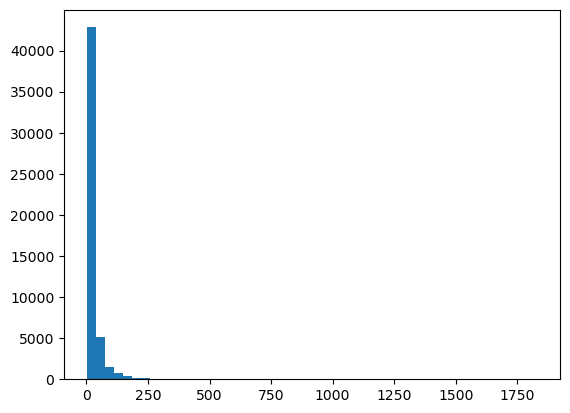

In [9]:
# check parcel count by block
parcel_geography_short.loc[:, 'Census2010Block'] = \
parcel_geography_short.loc[:, 'Census2010Block'].astype(int).astype(str).str.zfill(15)
parcel_by_block = \
parcel_geography_short.groupby(['Census2010Block'])['ParcelID'].nunique()
parcel_by_block = parcel_by_block.reset_index()
plt.hist(parcel_by_block['ParcelID'], bins = 50)
parcel_by_block.head(5)

In [10]:
print(len(psrc_parcels))
psrc_parcels = pd.merge(psrc_parcels,
                        parcel_geography_short,
                        left_on = ['parcelid', 'taz_p'],
                        right_on = ['ParcelID', 'taz_p'],
                        how = 'left')
print(len(psrc_parcels))

1302434
1302434


In [6]:
psrc_parcels.to_csv('SoundCast_processed/parcel_data_with_geography.csv',
                   index = False)


48171


,Census2010Block,ParcelID
0,530330001002001,9
1,530330001002002,2
2,530330001002005,12
3,530330001002008,3
4,530330001002009,2


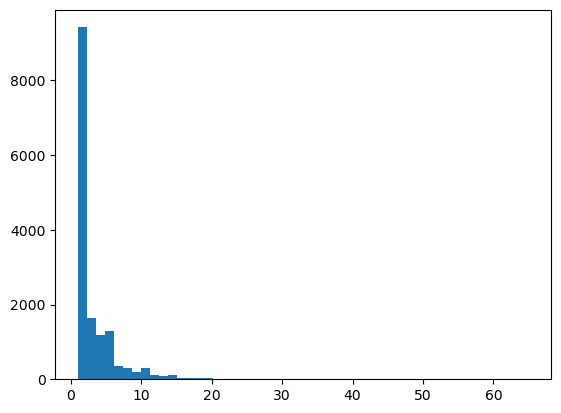

In [11]:
psrc_parcels_job_only = psrc_parcels.loc[psrc_parcels['emptot_p'] > 0]
print(len(psrc_parcels_job_only))
psrc_parcels_job_only.to_csv('SoundCast_processed/parcel_data_with_geography_job_only.csv',
                   index = False)

parcel_by_block = \
psrc_parcels_job_only.groupby(['Census2010Block'])['ParcelID'].nunique()
parcel_by_block = parcel_by_block.reset_index()
plt.hist(parcel_by_block['ParcelID'], bins = 50)
parcel_by_block.head(5)

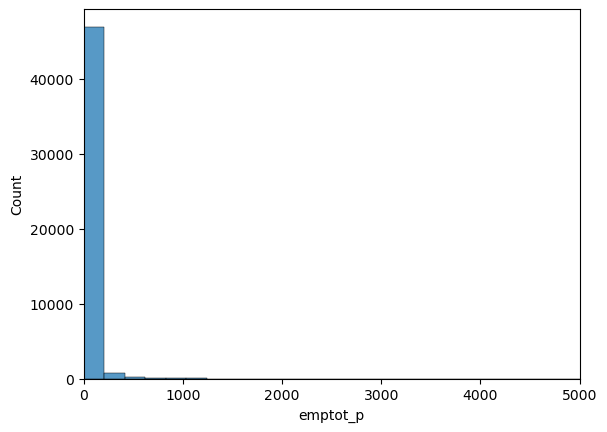

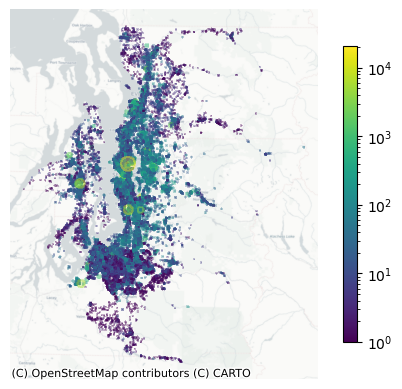

In [22]:
# create shapefile of parcel
import matplotlib
sns.histplot(psrc_parcels_job_only, x = 'emptot_p', bins = 100)
plt.xlim([0, 5000])
plt.show()
psrc_parcels_job_only_gdf = gps.GeoDataFrame(
    psrc_parcels_job_only, 
    geometry=gps.points_from_xy(psrc_parcels_job_only.xcoord_p, 
                                psrc_parcels_job_only.ycoord_p), crs=psrc_crs)

ax = psrc_parcels_job_only_gdf.plot(column = 'emptot_p',
                               cmap='viridis',
                               alpha = 0.3, 
                               markersize = 0.005 * psrc_parcels_job_only_gdf['emptot_p'],
                               vmin = 0, vmax =1000,
                               legend=True,
                               norm=matplotlib.colors.LogNorm(vmin=1, 
                                                              vmax = psrc_parcels_job_only_gdf['emptot_p'].max()),
                               legend_kwds = {'shrink': 0.8}, antialiased=False)
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = psrc_crs)
plt.axis('off')
plt.savefig('plot/parcel_level_emp.png', dpi = 300, bbox_inches = 'tight')
plt.show()

empedu


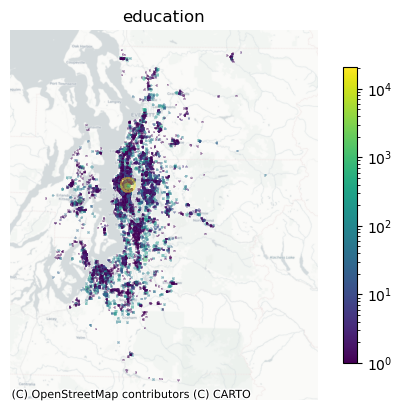

empfoo


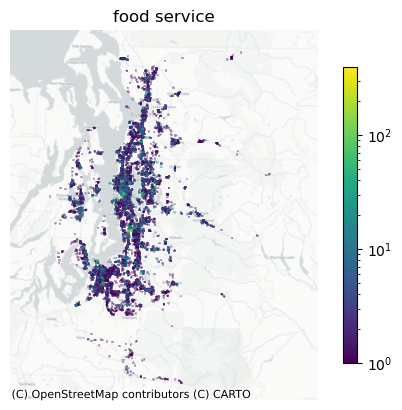

empgov


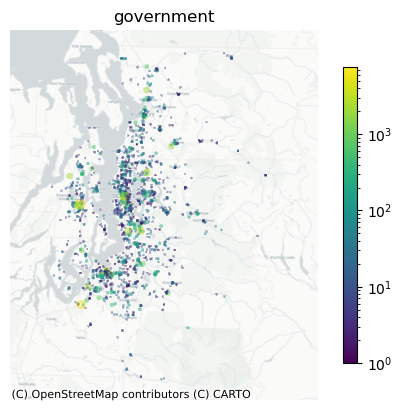

empind


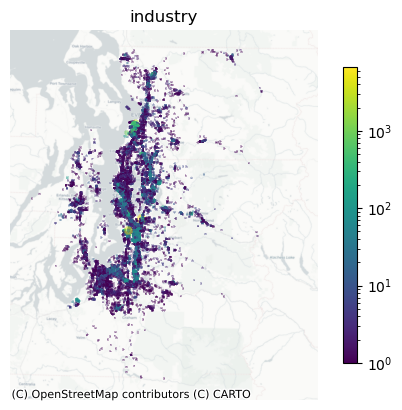

empmed


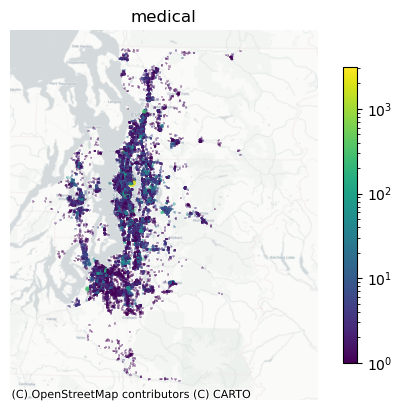

empofc


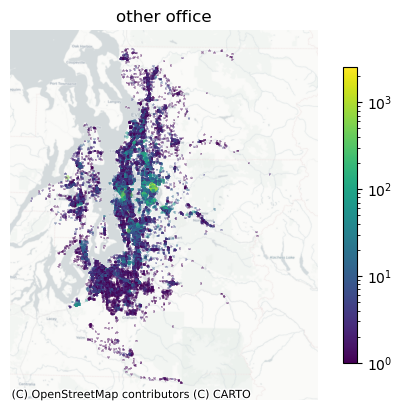

empoth


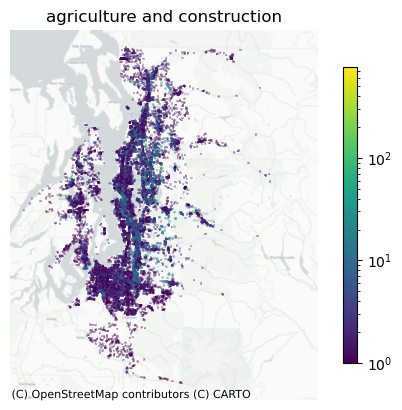

empret


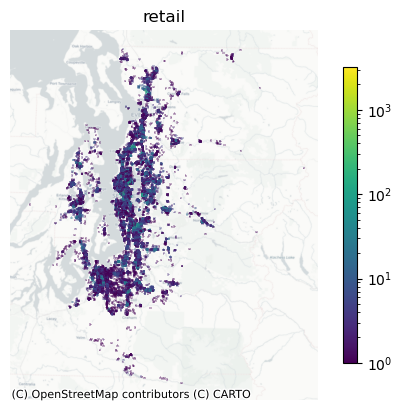

empsvc


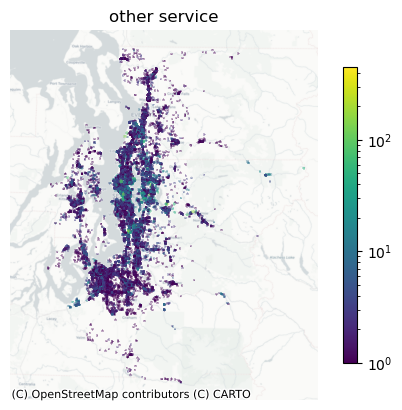

In [25]:
industry_attr = ['empedu_p', 'empfoo_p', 'empgov_p', 'empind_p', 'empmed_p',
       'empofc_p', 'empoth_p', 'empret_p', 'empsvc_p'] # 'emprsc_p'
ind_name_lookup = {'empedu_p': 'education', 
                   'empfoo_p': 'food service', 
                   'empgov_p': 'government', 
                   'empind_p': 'industry', 
                   'empmed_p': 'medical',
                   'empofc_p': 'other office', 
                   'empoth_p': 'agriculture and construction', 
                   'empret_p': 'retail', 
                   'emprsc_p': 'retail and service', 
                   'empsvc_p': 'other service'}
for ind in industry_attr: 
    ind_code = ind.split('_')[0]
    print(ind_code)
    ax = psrc_parcels_job_only_gdf.plot(column = ind,
                               cmap='viridis',
                               alpha = 0.3, 
                               markersize = 0.005 * psrc_parcels_job_only_gdf[ind],
                               vmin = 0, vmax =1000,
                               legend=True,
                               norm=matplotlib.colors.LogNorm(vmin=1, 
                                                              vmax = psrc_parcels_job_only_gdf[ind].max()),
                               legend_kwds = {'shrink': 0.8}, antialiased=False)
    cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = psrc_crs)
    plt.title(ind_name_lookup[ind])
    plt.axis('off')
    plt.savefig('plot/parcel_level_' + ind_code + '.png', dpi = 300, bbox_inches = 'tight')
    plt.show()

In [12]:
# PSRC employment data by cbg
# print(psrc_parcels.columns)
emp_attr = ['empedu_p', 'empfoo_p', 'empgov_p', 'empind_p', 'empmed_p',
       'empofc_p', 'empoth_p', 'empret_p', 'empsvc_p', 'emptot_p']
agg_var = ['CountyName', 'Census2010BlockGroup', 'BaseYear']
psrc_emp_by_cbg = psrc_parcels.groupby(agg_var)[emp_attr].sum()
psrc_emp_by_cbg = psrc_emp_by_cbg.reset_index()
print(len(psrc_emp_by_cbg))
print(psrc_emp_by_cbg.emptot_p.sum())
psrc_emp_by_cbg.head(5)

2645
2009687


,CountyName,Census2010BlockGroup,BaseYear,empedu_p,empfoo_p,empgov_p,empind_p,empmed_p,empofc_p,empoth_p,empret_p,empsvc_p,emptot_p
0,King,530330001001,2018,0,0,0,0,0,0,0,0,0,0
1,King,530330001002,2018,7,14,0,105,22,155,18,44,28,393
2,King,530330001003,2018,43,62,4,13,27,39,10,370,24,592
3,King,530330001004,2018,4,0,1,24,8,16,7,11,28,99
4,King,530330001005,2018,9,127,0,54,27,76,72,360,51,776


In [34]:
psrc_emp_by_cbg.to_csv('SoundCast_processed/employment_by_cbg_2018.csv', 
                       index = False)

In [ ]:
# load SynthFirm results
synthfirm_emp_by_cbg

In [13]:
# format PSRC data for comparison

# lehd_sectors = ['LEHD_Other', 'LEHD_Industrial', 'LEHD_Retail', 'LEHD_Office',
#                 'LEHD_Education', 'LEHD_Medical', 'LEHD_Service', 'LEHD_Government']
psrc_sector = ['PSRC_Education', 'PSRC_Government', 'PSRC_Industrial', 'PSRC_Medical',
              'PSRC_Other', 'PSRC_Retail', 'PSRC_Office', 'PSRC_Service']
psrc_emp_by_cbg.loc[:, 'GEOID'] = \
psrc_emp_by_cbg.loc[:, 'Census2010BlockGroup'].astype(float).astype(int)
psrc_emp_by_cbg.loc[:, 'PSRC_Education'] = psrc_emp_by_cbg.loc[:, 'empedu_p']
psrc_emp_by_cbg.loc[:, 'PSRC_Government'] = psrc_emp_by_cbg.loc[:, 'empgov_p']
psrc_emp_by_cbg.loc[:, 'PSRC_Industrial'] = psrc_emp_by_cbg.loc[:, 'empind_p']
psrc_emp_by_cbg.loc[:, 'PSRC_Medical'] = psrc_emp_by_cbg.loc[:, 'empmed_p']
psrc_emp_by_cbg.loc[:, 'PSRC_Other'] = psrc_emp_by_cbg.loc[:, 'empoth_p']
psrc_emp_by_cbg.loc[:, 'PSRC_Retail'] = psrc_emp_by_cbg.loc[:, 'empret_p']
psrc_emp_by_cbg.loc[:, 'PSRC_Office'] = psrc_emp_by_cbg.loc[:, 'empofc_p']
psrc_emp_by_cbg.loc[:, 'PSRC_Service'] = psrc_emp_by_cbg.loc[:, 'empfoo_p'] + \
psrc_emp_by_cbg.loc[:, 'empsvc_p']
# psrc_emp_by_cbg.head(5)
psrc_emp_by_cbg = psrc_emp_by_cbg.set_index('GEOID')
psrc_emp_to_compare = psrc_emp_by_cbg[psrc_sector]
psrc_emp_to_compare.loc[:, 'PSRC_Total'] = psrc_emp_to_compare[psrc_sector].sum(axis = 1)
print(psrc_emp_to_compare.PSRC_Total.sum())
psrc_emp_to_compare.head(5)

2009687


,PSRC_Education,PSRC_Government,PSRC_Industrial,PSRC_Medical,PSRC_Other,PSRC_Retail,PSRC_Office,PSRC_Service,PSRC_Total
GEOID,,,,,,,,,
530330001001,0,0,0,0,0,0,0,0,0
530330001002,7,0,105,22,18,44,155,42,393
530330001003,43,4,13,27,10,370,39,86,592
530330001004,4,1,24,8,7,11,16,28,99
530330001005,9,0,54,27,72,360,76,178,776


2645
2064805.0 2009687
Education
623.6 -0.15
Government
362.0 -0.96
Industrial
796.7 0.37
Medical
384.5 0.31
Other
24.5 0.98
Retail
767.7 0.23
Office
735.6 0.73
Service
104.8 0.91
Total
1630.4 0.68


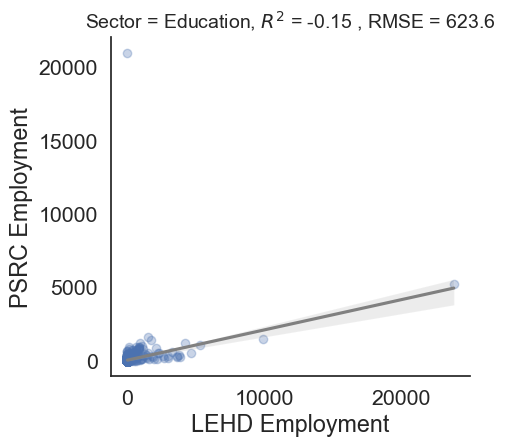

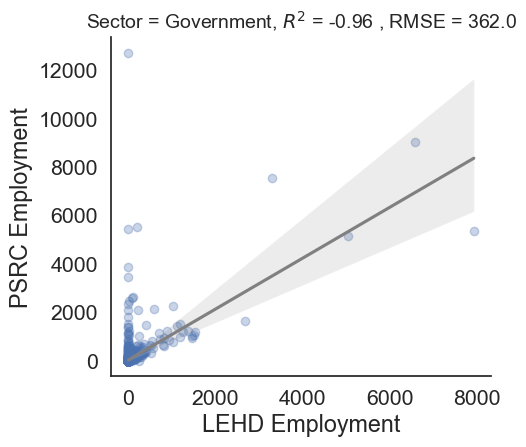

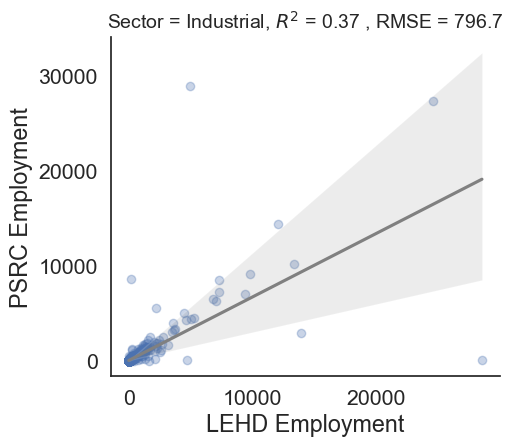

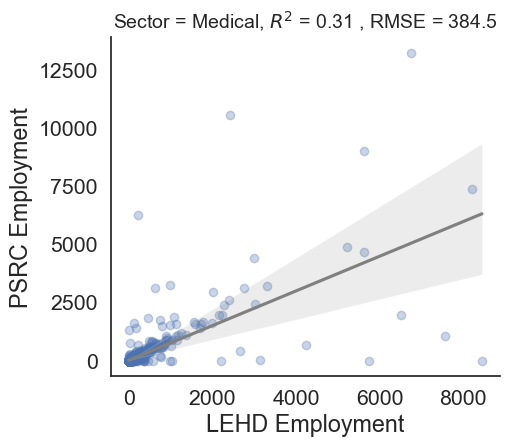

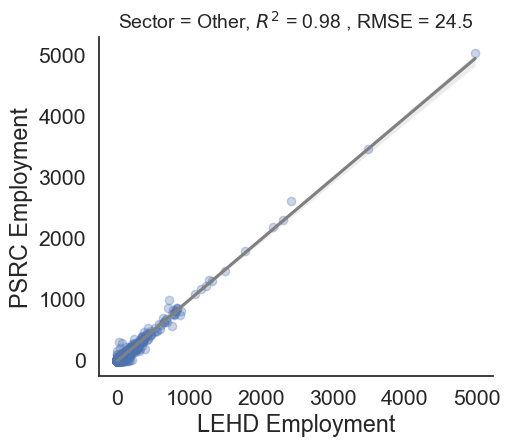

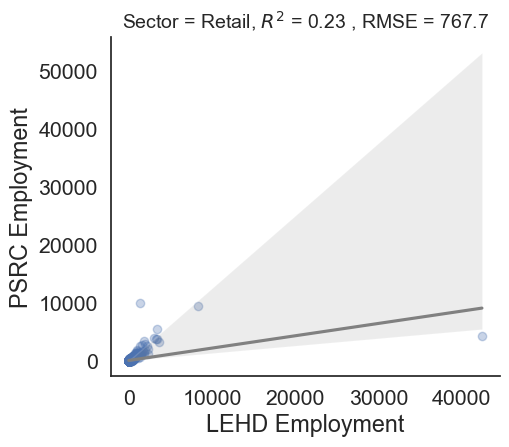

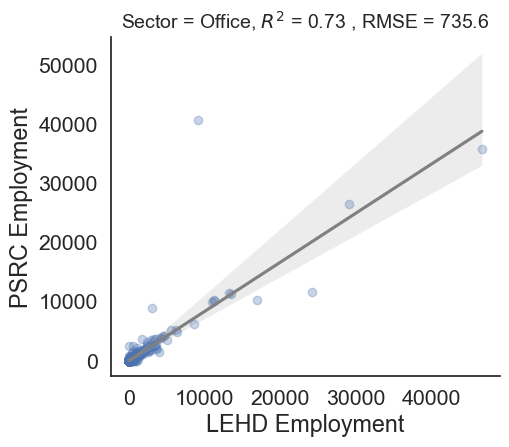

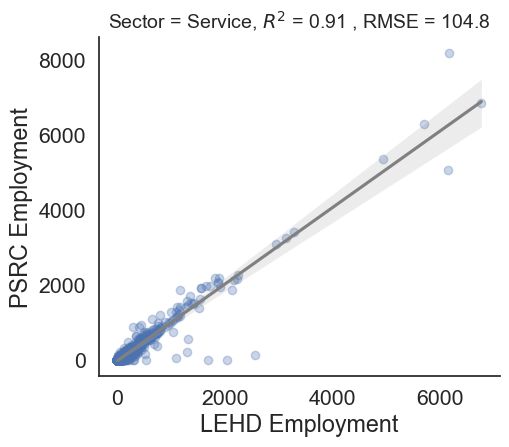

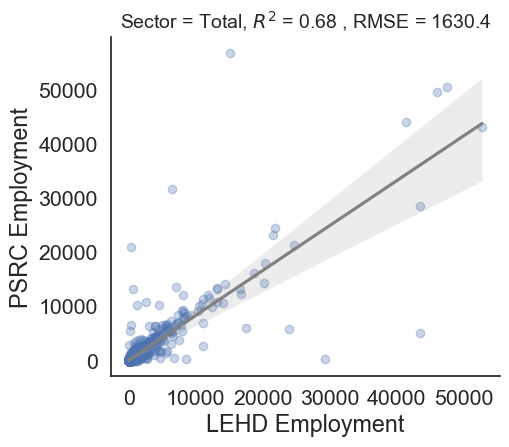

In [10]:
# compare employment from PSRC and LEHD
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import numpy as np

emp_to_compare = pd.merge(psrc_emp_to_compare, lehd_validation, 
                          left_index = True, right_index = True, how = 'left')

print(len(emp_to_compare))

joint_sector = ['Education', 'Government', 'Industrial', 'Medical',
              'Other', 'Retail', 'Office', 'Service', 'Total']
emp_to_compare.fillna(0, inplace = True)
print(emp_to_compare.LEHD_Total.sum(), emp_to_compare.PSRC_Total.sum())
emp_to_compare.head(5)

for sec in joint_sector:
    print(sec)
    lehd_attr = 'LEHD_' + sec
    psrc_attr = 'PSRC_' + sec

    rmse_emp = mean_squared_error(emp_to_compare[lehd_attr], 
                                  emp_to_compare[psrc_attr], squared = False)
    r2_emp = r2_score(emp_to_compare[lehd_attr], 
                      emp_to_compare[psrc_attr])
    rmse_emp = np.round(rmse_emp, 1)
    r2_emp = np.round(r2_emp, 2)
    print(rmse_emp, r2_emp)
    plt.style.use('seaborn-v0_8-white')
    # plt.rcParams['axes.facecolor'] = 'white'
    sns.set(font_scale=1.4)  # crazy big
    sns.set_style("white")
    sns.lmplot(
        data=emp_to_compare,
        x=lehd_attr, y=psrc_attr, 
        height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
        scatter_kws = {'alpha':0.3})
    # g.set_facecolor("white")
    
    # plt.xlim([0, 1300000])
    # plt.ylim([0, 1300000])
    plt.xlabel('LEHD Employment')
    plt.ylabel('PSRC Employment')
    plt.title('Sector = ' + sec + ', $R^{2}$ = ' + str(r2_emp) + \
              ' , RMSE = ' + str(rmse_emp), fontsize = 14)
    plt.savefig('plot/emp_by_cbg_' + sec +'_validation.png', dpi = 200,
               bbox_inches = 'tight')

In [16]:
# produce summary statistics
emp_to_compare_sums = pd.DataFrame(emp_to_compare.sum())
emp_to_compare_sums = emp_to_compare_sums.reset_index()
emp_to_compare_sums.columns = ['Var', 'Employment']
emp_to_compare_sums.loc[:, 'Source'] = \
emp_to_compare_sums.loc[:, 'Var'].str.split('_').str[0]
emp_to_compare_sums.loc[:, 'Sector'] = \
emp_to_compare_sums.loc[:, 'Var'].str.split('_').str[1]
emp_to_compare_sums.to_csv('SoundCast_processed/total_emp_validation_lehd.csv')

In [10]:
psrc_emp_by_cbg = psrc_parcels.groupby(['Census2010BlockGroup'])[['emptot_p']].sum()
psrc_emp_by_cbg = psrc_emp_by_cbg.reset_index()
psrc_emp_by_cbg.columns = ['GEOID', 'EMPLOYEE']
psrc_emp_by_cbg.loc[:, 'GEOID'] = \
psrc_emp_by_cbg.loc[:, 'GEOID'].astype(float).astype(int).astype(str)
psrc_emp_by_cbg.head(5)

,GEOID,EMPLOYEE
0,530330001001,0
1,530330001002,393
2,530330001003,592
3,530330001004,99
4,530330001005,776


In [27]:
state = '53'
analysis_year = 2018
region_cbg_map = block_groups(state = state, year = analysis_year)
# region_cbg_map.head(5)
region_cbg_map = region_cbg_map[['GEOID', 'ALAND', 'geometry']]
region_cbg_map.loc[:, 'GEOID'] = \
region_cbg_map.loc[:, 'GEOID'].astype(str).str.zfill(12)

region_cbg_map = region_cbg_map.merge(psrc_emp_by_cbg,
                                      on = 'GEOID',
                                      how = 'inner')
region_cbg_map.head(5)

,GEOID,ALAND,geometry,EMPLOYEE
0,530610518023,1847888,"POLYGON ((-122.28188 47.84291, -122.28146 47.8...",7036
1,530530634006,319199,"POLYGON ((-122.44199 47.17191, -122.44197 47.1...",40
2,530330219042,367206,"POLYGON ((-122.17557 47.72344, -122.17328 47.7...",218
3,530330219044,318915,"POLYGON ((-122.17558 47.72581, -122.17323 47.7...",0
4,530330219051,759979,"POLYGON ((-122.18723 47.74653, -122.18719 47.7...",513


EPSG:4269


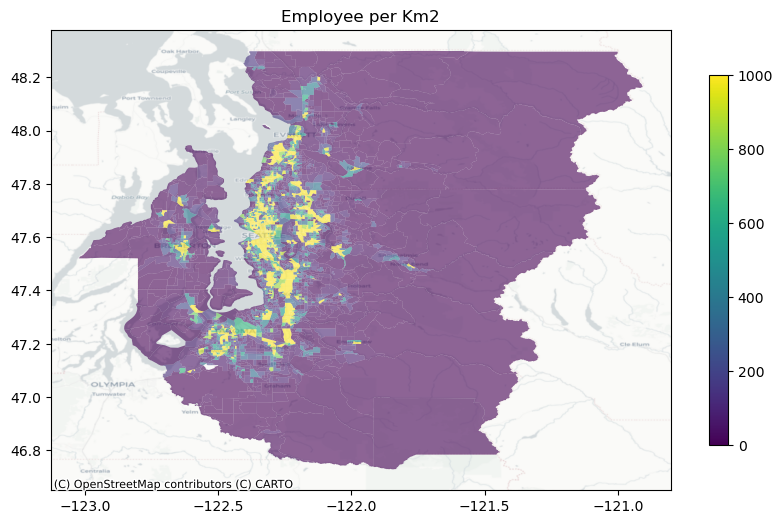

In [15]:
print(region_cbg_map.crs)
region_cbg_map.loc[:, 'emp_per_km2'] = \
region_cbg_map.loc[:, 'EMPLOYEE'] / region_cbg_map.loc[:, 'ALAND'] * 10**6
ax = region_cbg_map.plot(figsize = (10,12), 
                         column = 'emp_per_km2', 
                         cmap='viridis',
                         alpha = 0.6, 
                        vmin = 0, vmax =1000, 
                         linewidth=0.01, legend=True,
                          legend_kwds = {'shrink': 0.4})
plt.title('Employee per Km2')
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = 'EPSG:4269')
ax.grid(False)
plt.savefig('plot/PSRC_emp_density_2018.png', dpi = 300, bbox_inches = 'tight')

In [31]:
# load land use labels
print(psrc_parcels.lutype_p.unique())
land_use_code = pd.read_csv('SoundCast_processed/land_use_code.csv')
land_use_code.head(5)
psrc_parcels = pd.merge(psrc_parcels,
                        land_use_code, 
                        on = 'lutype_p', how = 'left')
print(len(psrc_parcels))
psrc_parcels.head(5)

[22 26 18  3 29 28 20 19 24 25 14  9 13 23 17  8 21 10  7 30  0  2  1 15
  6 12 27  5  4 11]
1302434


,aparks,empedu_p,empfoo_p,empgov_p,empind_p,empmed_p,empofc_p,empoth_p,empret_p,emprsc_p,...,CountyName,TAZ,BaseYear,GEOID10,place_name,State,County,FIPS,Definition,LU_Group
0,0,0,0,0,0,0,0,0,0,0,...,King,1019,2018,5.303303e+14,Kent,53,033,53033,Right-of-Way,Transportation and parking
1,0,0,0,0,0,0,0,0,0,0,...,King,1018,2018,5.303303e+14,Kent,53,033,53033,Vacant Developable,Vacant
2,0,0,0,0,0,0,0,0,0,0,...,King,1018,2018,5.303303e+14,Kent,53,033,53033,Office,Commercial
3,0,0,0,0,5,2,17,9,6,0,...,King,1018,2018,5.303303e+14,Kent,53,033,53033,Office,Commercial
4,0,0,0,0,0,0,0,0,0,0,...,King,1018,2018,5.303303e+14,Kent,53,033,53033,Vacant Developable,Vacant


In [32]:
land_use_by_cbg = \
psrc_parcels.groupby(['Census2010BlockGroup', 'LU_Group'])[['sqft_p']].sum()
land_use_by_cbg = land_use_by_cbg.reset_index()
land_use_by_cbg.columns = ['GEOID', 'Land use type', 'area_1000_sqft']
land_use_by_cbg.loc[:, 'GEOID'] = \
land_use_by_cbg.loc[:, 'GEOID'].astype(float).astype(int).astype(str)


In [33]:
land_use_by_cbg = \
land_use_by_cbg.sort_values(by = 'area_1000_sqft', ascending = False)
prime_land_use_by_cbg = land_use_by_cbg.groupby('GEOID').head(1)
prime_land_use_by_cbg = prime_land_use_by_cbg.reset_index()
prime_land_use_by_cbg.head(5)

region_cbg_map = region_cbg_map.merge(prime_land_use_by_cbg,
                                      on = 'GEOID',
                                      how = 'inner')


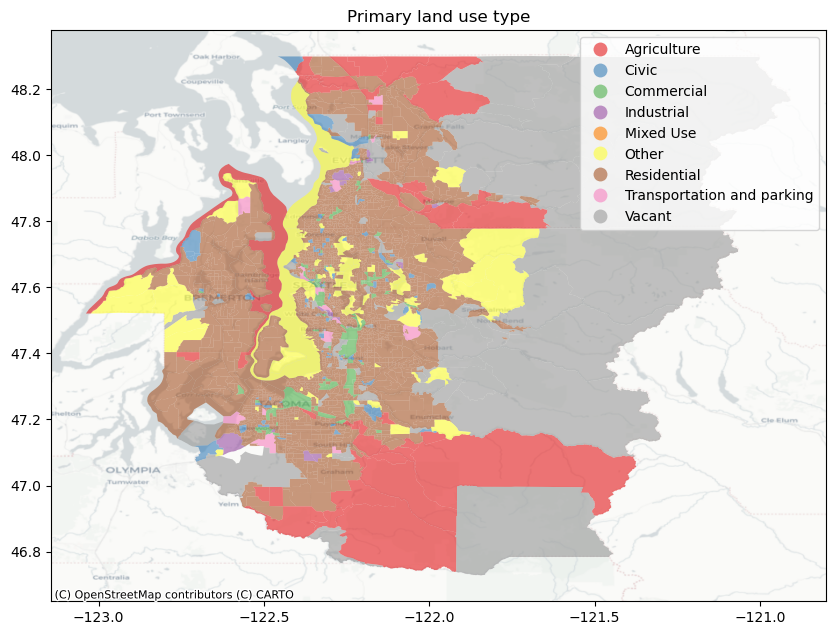

In [34]:
ax = region_cbg_map.plot(figsize = (10,12), 
                         column = 'Land use type', 
                         cmap='Set1',
                         alpha = 0.6, 
                        # vmin = 0, vmax =1000, 
                         linewidth=0.01, legend=True)
plt.title('Primary land use type')
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = 'EPSG:4269')
ax.grid(False)
plt.savefig('plot/PSRC_primary_lu_type_2018.png', dpi = 300, bbox_inches = 'tight')

In [4]:
db_cur = db_con.cursor()
db_cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(db_cur.fetchall())

[('externals_db',), ('externals_unadjusted',), ('external_trip_distribution',), ('enlisted_personnel',), ('base_year_scaling',), ('parking_zones',), ('psrc_zones',), ('job_trip_rates',), ('auto_externals',), ('group_quarters',), ('trip_rates',), ('special_generators',), ('rate_adjustments',), ('jblm_trips',), ('gravity_model_coefficients',), ('ixxi_mode_share',), ('mode_choice_parameters',), ('time_of_day_factors',), ('heavy_trucks',), ('truck_operating_costs',), ('truck_inputs',), ('seatac',), ('observed_transit_boardings',), ('hourly_counts',), ('acs_commute_mode_by_workplace_geog',), ('acs_commute_mode_home_tract',), ('district_worker_flows',), ('external_nonwork',), ('observed_corridor_speed',), ('light_rail_station_boardings',), ('taz_geography',), ('parcel_2014_geography',), ('running_emission_rates',), ('start_emission_rates',), ('job_attractions',), ('job_productions',), ('truck_time_of_day_factors',), ('daily_counts',), ('observed_external_volumes',), ('observed_screenline_vol

In [12]:
# TRY LOAD PSRC ZONE
psrc_zones_df = pd.read_sql_query("SELECT * FROM psrc_zones", db_con)
psrc_zones_df.head(5)

,record,taz,county,jblm,external
0,1,1,King,0,0
1,2,2,King,0,0
2,3,3,King,0,0
3,4,4,King,0,0
4,5,5,King,0,0


In [3]:
# LOAD PARCEL
parcel_2018_df = pd.read_sql_query("SELECT * FROM parcel_2018_geography", db_con)
parcel_2018_df.head(5)

,field1,ParcelID,rg_proposed,CityName,Census2010Block,Census2010BlockGroup,Census2010Tract,minority_geog,poverty_geog,GrowthCenterName,...,elderly_geog_vs_50_percent,elderly_geog_vs_reg_total,english_geog_vs_50_percent,english_geog_vs_reg_total,poverty_geog_vs_50_percent,poverty_geog_vs_reg_total,racial_geog_vs_50_percent,racial_geog_vs_reg_total,youth_geog_vs_50_percent,youth_geog_vs_reg_total
0,0,1,Core,Kent,5.303303e+14,5.303303e+11,5.303303e+10,2,1,Kent MIC,...,0,1,0,1,0,1,1,1,0,0
1,1,2,Core,Kent,5.303303e+14,5.303303e+11,5.303303e+10,2,1,Kent MIC,...,0,1,0,1,0,1,1,1,0,0
2,2,3,Core,Kent,5.303303e+14,5.303303e+11,5.303303e+10,2,1,Kent MIC,...,0,1,0,1,0,1,1,1,0,0
3,3,4,Core,Kent,5.303303e+14,5.303303e+11,5.303303e+10,2,1,Kent MIC,...,0,1,0,1,0,1,1,1,0,0
4,4,5,Core,Kent,5.303303e+14,5.303303e+11,5.303303e+10,2,1,Kent MIC,...,0,1,0,1,0,1,1,1,0,0


In [11]:
print(parcel_2018_df.columns)
print(parcel_2018_df[['ParcelID', 'place_name', 'FAZID', 'TAZ', 'taz_p', 
                      'parcel_id_x', 'parcel_id_y']].head(10))

Index(['field1', 'ParcelID', 'rg_proposed', 'CityName', 'Census2010Block',
       'Census2010BlockGroup', 'Census2010Tract', 'minority_geog',
       'poverty_geog', 'GrowthCenterName', 'FAZID', 'taz_p', 'parcel_id_x',
       'District', 'district_name', 'CountyName', 'TAZ', 'LowIncome',
       'PeopleofColor', 'BaseYear', 'GEOID10', 'place_name', 'parcel_id_y',
       'disability_geog_vs_50_percent', 'disability_geog_vs_reg_total',
       'elderly_geog_vs_50_percent', 'elderly_geog_vs_reg_total',
       'english_geog_vs_50_percent', 'english_geog_vs_reg_total',
       'poverty_geog_vs_50_percent', 'poverty_geog_vs_reg_total',
       'racial_geog_vs_50_percent', 'racial_geog_vs_reg_total',
       'youth_geog_vs_50_percent', 'youth_geog_vs_reg_total'],
      dtype='object')
   ParcelID place_name  FAZID   TAZ  taz_p  parcel_id_x  parcel_id_y
0         1       Kent   3600  1019   1019            1            1
1         2       Kent   3600  1018   1018            2            2
2         

In [4]:
# write output
parcel_2018_df.to_csv('parcel_2018_geography.csv', index = False)

In [9]:
print(psrc_parcels.columns)

psrc_parcels[['parcelid', 'taz_p']].head(10)

Index(['aparks', 'empedu_p', 'empfoo_p', 'empgov_p', 'empind_p', 'empmed_p',
       'empofc_p', 'empoth_p', 'empret_p', 'emprsc_p', 'empsvc_p', 'emptot_p',
       'hh_p', 'lutype_p', 'mfunits', 'nparks', 'parcelid', 'parkdy_p',
       'parkhr_p', 'ppricdyp', 'pprichrp', 'sfunits', 'sqft_p', 'stugrd_p',
       'stuhgh_p', 'stuuni_p', 'taz_p', 'xcoord_p', 'ycoord_p'],
      dtype='object')


,parcelid,taz_p
0,1,1019
1,2,1018
2,3,1018
3,4,1018
4,5,1018
5,6,1018
6,7,1019
7,8,1018
8,9,1018
9,10,1018


In [20]:
truck_volume_df = pd.read_sql_query("SELECT * FROM heavy_trucks", db_con)
print(len(truck_volume_df))
print(truck_volume_df.columns)
truck_volume_df.head(5)
truck_volume_df.to_csv('truck_volume.csv', index = False)

994
Index(['record', 'atri_zone', 'taz', 'year', 'htkpro', 'htkatt'], dtype='object')
